# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [126]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from scipy.stats import ks_2samp

import statsmodels.formula.api as smf
import statsmodels.api as sm

import patsy

%matplotlib inline

In [2]:
df = pd.read_csv('previsao_de_renda.csv')
df

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2016-03-01,16006,F,False,True,0,Empresário,Secundário,Solteiro,Casa,48,13.887671,1.0,7990.58
14996,14996,2016-03-01,3722,F,False,True,0,Pensionista,Superior completo,Solteiro,Casa,57,NaN,1.0,10093.45
14997,14997,2016-03-01,6194,F,True,True,0,Assalariado,Superior completo,Casado,Casa,45,7.832877,2.0,604.82
14998,14998,2016-03-01,4922,M,True,False,0,Empresário,Superior completo,Casado,Casa,36,4.298630,2.0,3352.27


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [7]:
# 1) Separe a base em treinamento e teste (25% para teste, 75% para treinamento

new_df = df.drop(['Unnamed: 0','data_ref','id_cliente'], axis=1).fillna(0)
new_df = pd.get_dummies(new_df)

train_df, test_df = train_test_split(new_df, test_size=0.25, random_state=42)

X_train = train_df.drop('renda', axis=1) 
y_train = train_df['renda']

X_test = test_df.drop('renda', axis=1)
y_test = test_df['renda']

print(f'Training size: {train_df.shape}')
print(f'Test size: {test_df.shape}')

Training size: (11250, 30)
Test size: (3750, 30)


In [9]:
# 2)Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o na base de testes. 
# Qual o melhor modelo?

alpha_values = [0, 0.001, 0.005, 0.01, 0.05, 0.1]
resultados_ridge = []

for alpha in alpha_values:
    model_ridge = Ridge(alpha=alpha)
    model_ridge.fit(X_train, y_train)
    y_pred = model_ridge.predict(X_test)
    r_squared = model_ridge.score(X_test, y_test)
    resultados_ridge.append({'alpha': alpha, 'r_squared': r_squared})

df_ridge_results = pd.DataFrame(resultados_ridge)
print(df_ridge_results)
print('####################')
print('The best r-squared its alpha 0.1')

   alpha  r_squared
0  0.000   0.268425
1  0.001   0.268458
2  0.005   0.268458
3  0.010   0.268458
4  0.050   0.268458
5  0.100   0.268459
####################
The best r-squared its alpha 0.1


In [11]:
# 3 Faça o mesmo que no passo 2, com uma regressão LASSO. Qual método chega a um melhor resultado?

alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1]
resultados_lasso = []

for alpha in alpha_values:
    model_lasso = Lasso(alpha=alpha, max_iter=10000)
    model_lasso.fit(X_train, y_train)   
    y_pred = model_lasso.predict(X_test)
    r_squared = model_lasso.score(X_test, y_test) 
    resultados_lasso.append({'alpha': alpha, 'r_squared': r_squared})

df_lasso_results = pd.DataFrame(resultados_lasso)
print(df_lasso_results)
print('####################')
print('The best r-squared its alpha 0.1, again')

C:\Users\Meu Computador\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.174e+10, tolerance: 7.723e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Meu Computador\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e+10, tolerance: 7.723e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Meu Computador\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

   alpha  r_squared
0  0.001   0.268458
1  0.005   0.268458
2  0.010   0.268459
3  0.050   0.268464
4  0.100   0.268470
####################
The best r-squared its alpha 0.1, again


In [28]:
# 4) Rode um modelo stepwise. Avalie o R2 na base de testes. Qual o melhor resultado?

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       verbose=True):
    """
    Realiza seleção de variáveis com abordagem stepwise baseada em p-value.
    Retorna o modelo final ajustado e o R².
    """
    # Garantir que os dados estejam no tipo float
    X = X.astype(float)
    y = y.astype(float)

    # Alinha os índices de X e y
    X, y = X.align(y, join='inner', axis=0)

    included = list(initial_list)

    while True:
        changed = False

        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)

        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]

        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f'Add  {best_feature:30} with p-value {best_pval:.6}')

        # Backward step
        if included:
            model = sm.OLS(y, sm.add_constant(X[included])).fit()
            # Exclui o intercept (const)
            pvalues = model.pvalues.iloc[1:] 
            worst_pval = pvalues.max() 
            if worst_pval > threshold_out:
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                changed = True
                if verbose:
                    print(f'Drop {worst_feature:30} with p-value {worst_pval:.6}')

        if not changed:
            break

    final_model = sm.OLS(y, sm.add_constant(X[included])).fit()
    r2 = final_model.rsquared

    if verbose:
        print(f"Final R²: {r2:.6f}")
    
    return included, r2

variaveis, r2 = stepwise_selection(X_train, y_train, verbose=True)


Add  tempo_emprego                  with p-value 0.0
Add  sexo_F                         with p-value 2.29624e-266
Add  sexo_M                         with p-value 0.0
Add  tipo_renda_Pensionista         with p-value 3.34101e-56
Add  tipo_renda_Empresário          with p-value 1.77532e-07
Add  educacao_Superior completo     with p-value 1.16378e-05
Add  idade                          with p-value 2.31163e-06
Final R²: 0.258348


## 5) Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?

 For me, the best model is the one that uses LASSO, because the R2 is higher.

In [120]:
# 6) Partindo dos modelos que você ajustou, tente melhorar o R2 na base de testes. 
# Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.

y, X = patsy.dmatrices(
    '''np.log(renda) ~ C(sexo) * idade
    + C(tipo_renda) * tempo_emprego
    + C(educacao) * idade
    + C(estado_civil) * qtd_filhos
    + C(tipo_residencia) * posse_de_imovel
    + posse_de_veiculo
    + qt_pessoas_residencia''',
    data=df_model,
    return_type='dataframe'
)

model_lasso = sm.OLS(y, X).fit()
df_model['model_lasso'] = model_lasso.resid

print(model_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     197.4
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        13:07:52   Log-Likelihood:                -16180.
No. Observations:               15000   AIC:                         3.244e+04
Df Residuals:                   14958   BIC:                         3.276e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

R² na base de treino: 0.3705
R² na base de teste: 0.3559


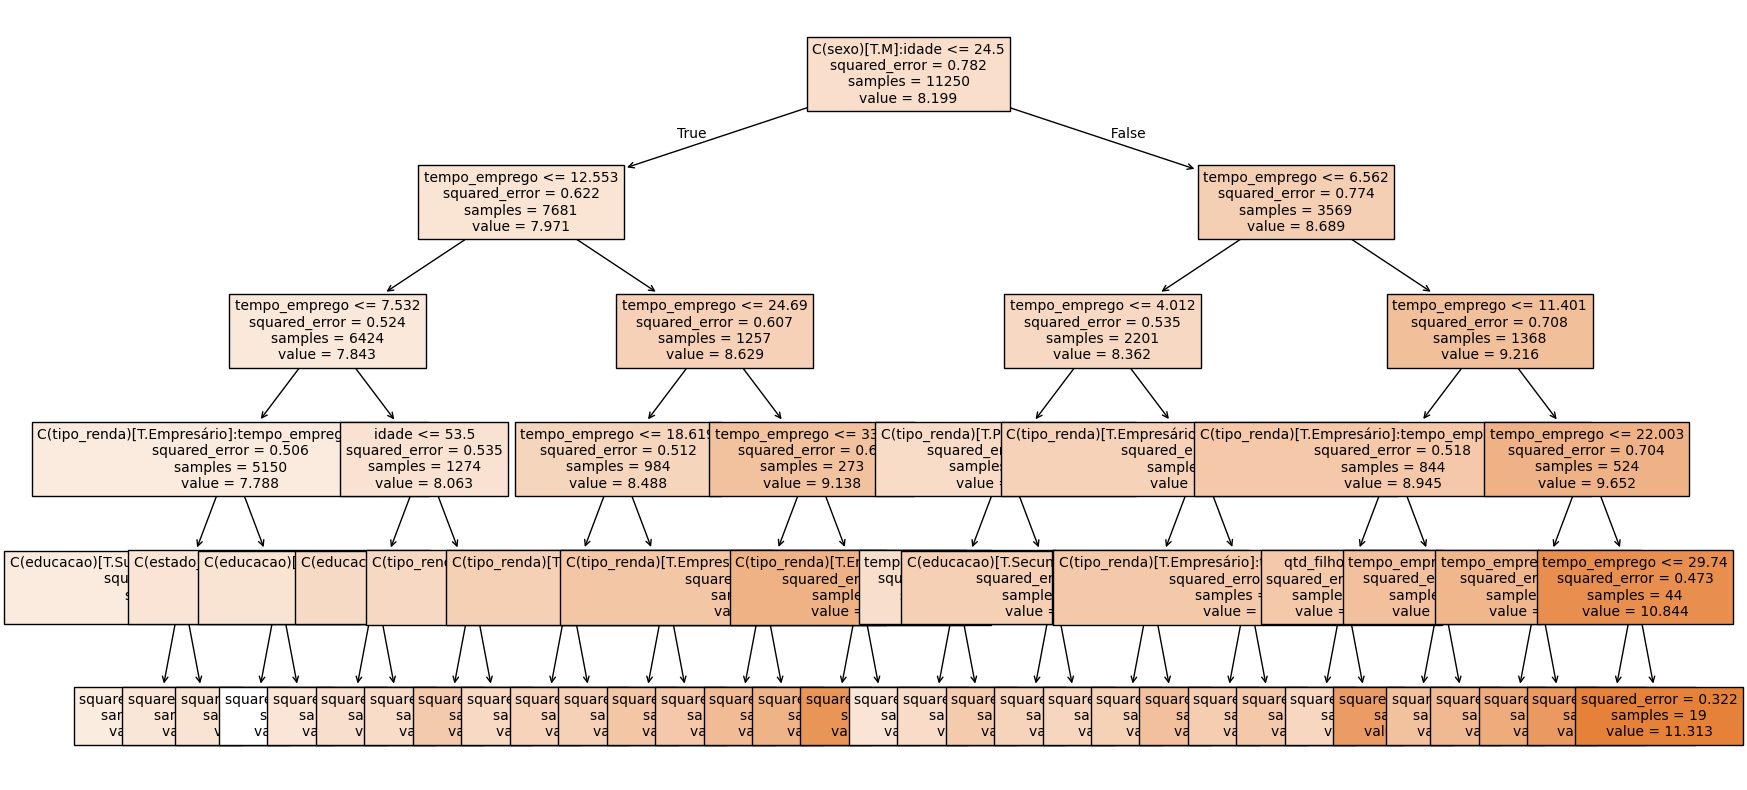

In [130]:
# 7) Ajuste uma árvore de regressão e veja se consegue um R2 melhor com ela.

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)

print(f'R² na base de treino: {r2_score(y_train, y_pred_train):.4f}')
print(f'R² na base de teste: {r2_score(y_test, y_pred_test):.4f}')

plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns, filled=True, fontsize=10)
plt.show()